vae3　オートエンコーダー

参考文献　【超初心者向け】VAEの分かりやすい説明とPyTorchの実装
           https://tips-memo.com/vae-pytorch

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/jpynb"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/jpynb


In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 6.8 MB/s 


In [5]:
import sys
sys.path.append("../minictorch")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import generator as GN
import converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST('~/mnist', train=True,  download=True, transform=transform)
dataset_valid = datasets.MNIST('~/mnist', train=False, download=True, transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

ニューラルネットワークの定義

In [7]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum() / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum() / len(mean)
  return y

import torch.distributions as td

class VAE(torch.nn.Module):
  def __init__( self,  t, x_dim,  z_dim ):
    super(VAE, self).__init__()
    self.x_dim = x_dim
    self.z_dim = z_dim
    self.fc1 = nn.Linear(x_dim, 20)
    self.bn1 = nn.BatchNorm1d(20)
    self.fc2_mean = nn.Linear(20, z_dim)
    self.fc2_var  = nn.Linear(20, z_dim)

    self.fc3   = nn.Linear(z_dim, 20)
    self.drop1 = nn.Dropout(p=0.2)
    self.fc4   = nn.Linear(20, x_dim)

    self.target = t

    #nn.init.constant_(self.fc1.bias,0)
    #nn.init.constant_(self.fc2_mean.bias,0)
    #nn.init.constant_(self.fc2_var.bias,0)
    #nn.init.constant_(self.fc3.bias,0)
    #nn.init.constant_(self.fc4.bias,0)

    self.bce1 = nn.BCELoss()
  
  def forward( self, x0 ):
    # encoder
    x = x0.view(-1, self.x_dim)
    x = F.relu( self.fc1(x) )
    x = self.bn1( x )
    self.mean    = self.fc2_mean(x)
    self.log_var = self.fc2_var(x)

    # reparametrization
    self.std = torch.exp( 0.5 * self.log_var )
    q_z = td.normal.Normal( self.mean, self.std )
    self.z = q_z.rsample()

    # decoder
    y = F.relu(self.fc3(self.z))
    y = self.drop1(y)
    #y = self.fc4(y)
    y = torch.sigmoid(self.fc4(y))
    ##return y
    self.out = y 
    #print("y ", len(y), y.size() )
    #print("x",x.shape)
    
    e1 = F.binary_cross_entropy( y , x0, reduction="mean" )
    #e1 = self.bce1(y, x)

    p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
    e2  = td.kl_divergence( q_z, p_z ).sum()

    return (e1+e2)

In [8]:
def test( x, t ):
 
  model = VAE( t, x_dim=28*28, z_dim=10 )

  trace = torch.jit.trace( model, x, strict=True )
  print(trace.graph)

#x = x_train.clone().detach()
#torch.reshape( x, (-1,n_in) )

#x = x[0:n_batch,:]

#e = torch.randn( n_batch, 2 )

itr = iter(dataloader_train)
x, t = itr.next()

print(x.shape)
print(t.shape)

test( x, t )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1000, 784])
torch.Size([1000])
graph(%self.1 : __torch__.VAE,
      %x0 : Float(1000, 784, strides=[784, 1], requires_grad=0, device=cpu)):
  %207 : __torch__.torch.nn.modules.linear.___torch_mangle_3.Linear = prim::GetAttr[name="fc4"](%self.1)
  %204 : __torch__.torch.nn.modules.dropout.Dropout = prim::GetAttr[name="drop1"](%self.1)
  %203 : __torch__.torch.nn.modules.linear.___torch_mangle_2.Linear = prim::GetAttr[name="fc3"](%self.1)
  %200 : __torch__.torch.nn.modules.linear.___torch_mangle_1.Linear = prim::GetAttr[name="fc2_var"](%self.1)
  %197 : __torch__.torch.nn.modules.linear.___torch_mangle_0.Linear = prim::GetAttr[name="fc2_mean"](%self.1)
  %194 : __torch__.torch.nn.modules.batchnorm.BatchNorm1d = prim::GetAttr[name="bn1"](%self.1)
  %188 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc1"](%self.1)
  %43 : int = prim::Constant[value=-1]() # <ipython-input-7-c797bd6570ac>:45:0
  %44 : int = prim::Constant[value=784]() # <ipython-input-7-c797bd

In [9]:
def generate_json( json_path, input, t ):

    model = VAE( t, x_dim=28*28, z_dim=10 )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [10]:
torch.manual_seed( 1 )

project = 'vae3'
json_path = '../network/' + project +'.json'

itr = iter(dataloader_train)
x, t = itr.next()

torch.manual_seed( 1 )

#model = generate_json( json_path, x, t )

e = torch.randn( 1000, 10 )
print("eps",e)
model = generate_json( json_path, x, e )

#x.requires_grad = True

with torch.set_grad_enabled(True):
  #model.eval()
  model.train()
  output = model( x )
  print("output",output)
  output.backward()
  #print("output",output.grad)
  print("input_grad",x.grad)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


eps tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.0112, -0.4718,  2.0793,  ..., -1.4960,  0.7010, -0.3290],
        [ 0.2317, -1.0762,  0.1955,  ...,  0.4263,  2.1063, -1.6123],
        [ 0.7102,  0.1944, -0.2268,  ...,  0.8306,  0.3967, -0.8857]])
[SAVE] ../network/vae3.json
skip: VAE/Linear[fc1]/weight/177
skip: VAE/Linear[fc1]/weight/177
skip: VAE/BatchNorm1d[bn1]/weight/182
skip: VAE/BatchNorm1d[bn1]/weight/182
skip: VAE/BatchNorm1d[bn1]/weight/182
skip: VAE/BatchNorm1d[bn1]/weight/182
skip: VAE/Linear[fc2_mean]/weight/185
skip: VAE/Linear[fc2_mean]/weight/185
skip: VAE/Linear[fc2_var]/weight/188
skip: VAE/Linear[fc2_var]/weight/188
skip: VAE/Linear[fc3]/weight/191
skip: VAE/Linear[fc3]/weight/191
skip: VAE/Linear[fc4]/weight/195
skip: VAE/Linear[fc4]/weight/195
output tensor(2849.7642, grad_fn=<

In [ ]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    print("input shape",input_x.shape)
    print("input",input_x)

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, "src", model, x, json_path )"""

In [11]:
CV.convert_json( project, "../src", model, x, json_path )

[JSON] ../network/vae3.json
param: xin  - str loop  5000  /  97999
param: xin  - str loop  10000  /  97999
param: xin  - str loop  15000  /  97999
param: xin  - str loop  20000  /  97999
param: xin  - str loop  25000  /  97999
param: xin  - str loop  30000  /  97999
param: xin  - str loop  35000  /  97999
param: xin  - str loop  40000  /  97999
param: xin  - str loop  45000  /  97999
param: xin  - str loop  50000  /  97999
param: xin  - str loop  55000  /  97999
param: xin  - str loop  60000  /  97999
param: xin  - str loop  65000  /  97999
param: xin  - str loop  70000  /  97999
param: xin  - str loop  75000  /  97999
param: xin  - str loop  80000  /  97999
param: xin  - str loop  85000  /  97999
param: xin  - str loop  90000  /  97999
param: xin  - str loop  95000  /  97999
{'name': 'VAE/Linear[fc1]/weight/211', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'VAE/Linear[fc1]/bias/210', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0

In [16]:
!g++ -std=c++14 ../src/vae3.cpp ../src/vae3_param.cpp  -I ../../../ctorch/lib -lcblas -o ../bin/vae3

(注意) ctorch/libにxtensor関連のincludeを置いています。

In [17]:
!../bin/vae3

### forward computation ...
ndim=2
{ 2849.754395}
### backward computation ...
input_grad{{-0.213298,  0.093343,  0.278396, ..., -0.041569,  0.156434, -0.147534},
 { 0.075242,  0.074864,  0.075545, ..., -0.070674,  0.093789,  0.091534},
 {-0.245654,  0.425683,  0.023375, ..., -0.074347, -0.078207,  0.111524},
 ..., 
 {-0.08386 ,  0.088923,  0.00665 , ..., -0.045123,  0.000524,  0.017924},
 {-0.17629 ,  0.145098, -0.061603, ...,  0.09536 , -0.144651,  0.082908},
 { 0.450589, -0.301483, -0.302051, ..., -0.483272, -0.520281,  0.51357 }}


以下、未完

In [ ]:
torch.manual_seed( 1 )

project = 'vae3'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

n_batch = 32 # 1792

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr=0.001
opt = torch.optim.SGD(net.parameters(), lr)
#mse = torch.nn.MSELoss()

epoch_loss = []
epoch_num = 5000; #201
for epoch in range(epoch_num):

  loss = net( x )

  print("loss",loss)

  opt.zero_grad()
  loss.backward()
  #print("fc1_w",model.fc1.weight.grad)
  #print("fc1_b",model.fc1.bias.grad)
  #print("fc1_rx",model.fc1)
  #print("fc1_z",model.rz.grad)
  """
  print("fc2_mean_w",model.fc2_mean.weight.grad)
  print("fc2_mean_b",model.fc2_mean.bias.grad)
  print("fc2_var_w",model.fc2_var.weight.grad)
  print("fc2_var_b",model.fc2_var.bias.grad)
  """
  #print("output",output.grad)

  opt.step()
  print("EPOCH: {} loss: {}".format(epoch, loss))
  epoch_loss.append( loss )
 

学習の収束の図化 (python)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

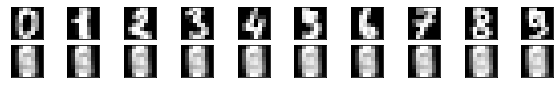

In [ ]:
n_img2=10
x2=x[:n_img2]

o = net.out.to('cpu').detach().numpy().copy()

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

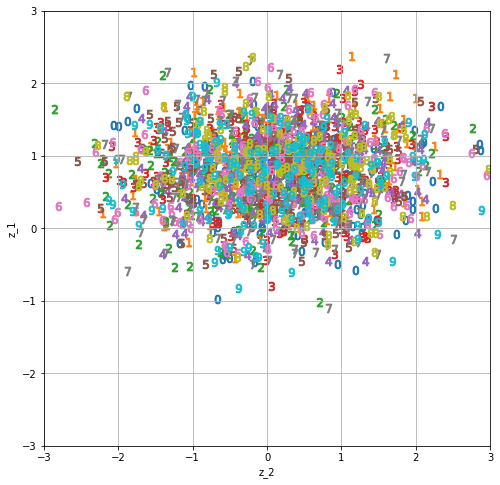

In [ ]:
t2 = t_train[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

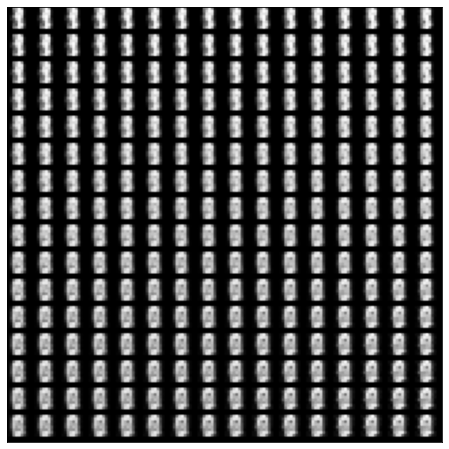

In [ ]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

最適化実行

全入力データを vae1_data.cpp に出力する

In [ ]:
def output_datafile( folder, project, in_data ):
    data_fname = project + "_data.cpp"
    data_path  = folder + "/" + data_fname

    # save data file
    code = CV.c_data_generator( in_data )
    if len( code ) > 0:
       print( "[DATA]", data_path )
       ofparam = open( data_path, "w" )
       ofparam.write( code )

output_datafile( "src", project, dd )

[DATA] src/vae1_data.cpp


In [ ]:
!g++ -std=c++14 ./src/vae1_opt.cpp ./src/vae1_param.cpp  ./src/vae1_data.cpp  -I ./lib -lcblas -o ./bin/vae1_opt

In [ ]:
!./bin/vae1_opt

batch1 1797,64
batch2 56,32
epoch_num : 200
total_loss 0 loss-2252.21
epoch 0 - loss { 33.315163}
total_loss 1 loss-1722.82
epoch 1 - loss { 29.588335}
total_loss 2 loss-1636.86
epoch 2 - loss { 28.864582}
total_loss 3 loss-1608.91
epoch 3 - loss { 28.606874}
total_loss 4 loss-1596.23
epoch 4 - loss { 28.399221}
total_loss 5 loss-1585.78
epoch 5 - loss { 28.196524}
total_loss 6 loss-1577.11
epoch 6 - loss { 28.112505}
total_loss 7 loss-1569.49
epoch 7 - loss { 27.971659}
total_loss 8 loss-1561.71
epoch 8 - loss { 27.893692}
total_loss 9 loss-1558.49
epoch 9 - loss { 27.743196}
total_loss 10 loss-1550.25
epoch 10 - loss { 27.667107}
total_loss 11 loss-1542.64
epoch 11 - loss { 27.463993}
total_loss 12 loss-1531.02
epoch 12 - loss { 27.312462}
total_loss 13 loss-1523.03
epoch 13 - loss { 27.131021}
total_loss 14 loss-1516.12
epoch 14 - loss { 26.991722}
total_loss 15 loss-1509.93
epoch 15 - loss { 26.916931}
total_loss 16 loss-1504.78
epoch 16 - loss { 26.820826}
total_loss 17 loss-1500.

c++ からの出力ファイルの読み込み

In [ ]:
#load out file
f = open('./vae1.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('vae1.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("pred =", n1,n2 )
#print( y_pred )

# load z file
f3 = open('vae1.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[33.315163, 29.588335, 28.864582, 28.606874, 28.399221, 28.196524, 28.112505, 27.971659, 27.893692, 27.743196, 27.667107, 27.463993, 27.312462, 27.131021, 26.991722, 26.916931, 26.820826, 26.766125, 26.719814, 26.643881, 26.562258, 26.530371, 26.381765, 26.348427, 26.247, 26.206261, 26.074146, 26.01207, 25.915354, 25.825443, 25.789684, 25.73243, 25.681158, 25.596586, 25.59939, 25.504528, 25.552197, 25.476049, 25.487141, 25.430082, 25.386908, 25.368185, 25.426172, 25.372349, 25.319706, 25.368671, 25.2885, 25.297209, 25.240149, 25.268908, 25.263052, 25.249092, 25.244768, 25.199209, 25.200945, 25.177311, 25.178787, 25.208733, 25.133116, 25.14896, 25.134329, 25.100975, 25.088497, 25.06917, 25.017958, 25.077044, 24.987011, 24.995789, 24.962414, 24.969925, 24.969854, 24.992798, 25.016535, 24.978632, 24.912752, 24.906364, 24.89068, 25.001881, 24.921247, 24.864115, 24.793262, 24.843008, 24.793819, 24.725113, 24.733715, 24.677114, 24.653231, 24.744532, 24.675917, 24.748131, 24.66044

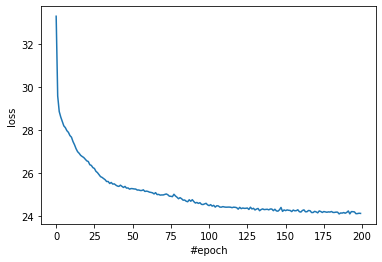

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

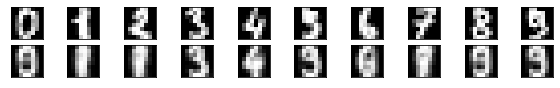

In [ ]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

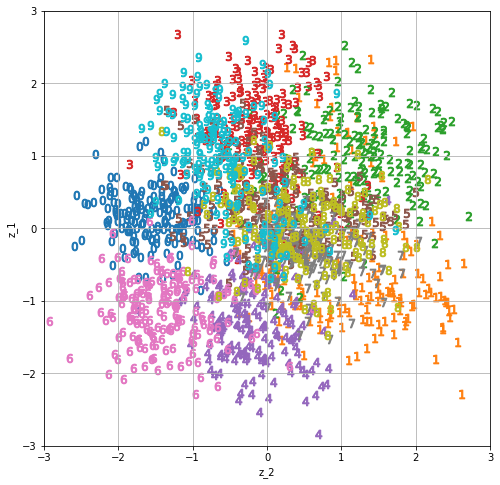

In [ ]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [ ]:
import torch.distributions as tdist

n = tdist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

e = n.sample((n_mid,))

In [ ]:
e

tensor([[ 0.5516],
        [-1.4746],
        [-1.2032],
        [-0.4709],
        [ 1.0430],
        [-0.9447],
        [ 0.7663],
        [-0.8108],
        [-0.7571],
        [ 0.6683],
        [-0.9177],
        [-0.1356],
        [-0.8786],
        [ 3.5638],
        [-1.4244],
        [-0.5050]])

In [ ]:
e2= torch.randn(n_mid)
print(e2)

tensor([ 1.4625,  0.0852,  0.2403, -0.7425, -1.1566, -1.9472, -0.0739,  1.4408,
        -1.5811,  0.1749,  1.1583,  0.6945, -0.4813, -0.2892,  1.3323, -0.9172])


In [ ]:
!g++ -std=c++14 ./src/mse1.cpp ./src/mse1_param.cpp -D_DEBUG -I ./lib -lcblas -o ./bin/mse1

In [ ]:
!./bin/mse1

### forward computation ...
linear(forward)
relu(forward)
linear(forward)
relu(forward)
linear(forward)
list_contruct(forward)
ListConstruct 
ListConstruct ,0 {{-0.04004 },
 {-0.019917},
 {-0.061454},
 {-0.023198},
 {-0.032469},
 {-0.050212},
 {-0.019786},
 {-0.03569 },
 {-0.01788 },
 {-0.055528},
 {-0.055517},
 {-0.010356},
 {-0.011153},
 {-0.041535},
 {-0.034578},
 {-0.013977},
 {-0.050152},
 {-0.044559},
 {-0.055405},
 {-0.023627},
 {-0.039049},
 {-0.055502},
 {-0.041154},
 {-0.040799},
 {-0.062593},
 {-0.014014},
 {-0.042788},
 {-0.065264},
 {-0.05553 },
 {-0.066007},
 {-0.055466},
 {-0.027234},
 {-0.04949 },
 {-0.052115},
 {-0.017279},
 {-0.014066},
 {-0.034744},
 {-0.014043},
 {-0.055396},
 {-0.015943},
 {-0.064241},
 {-0.013689},
 {-0.01025 },
 {-0.033734},
 {-0.051932},
 {-0.055529},
 {-0.014987},
 {-0.046881},
 {-0.054648},
 {-0.063072},
 {-0.060785},
 {-0.024952},
 {-0.027145},
 {-0.048851},
 {-0.011824},
 {-0.046802},
 {-0.043347},
 {-0.036935},
 {-0.011203},
 {-0.014471},
 